# Activité "Sélectionnez le nombre de voisins dans un kNN pour une régression"

Utiliser la version régression du K-nn afin de prédire la qualité du vin, évaluer le modèle pour choisir les meilleurs hyper-paramètres à l’aide d’une grid search (implémentation personnalisée). 

Optimiser l’erreur quadratique moyenne (Mean Squared Error), observer le comportement de la MSE et la comparer à celui du coefficient de détermination (R^2).

Comparer les performances obtenues avec celles d’une baseline naïve et des différentes heuristiques.

3 étapes:
1. Initialisation des données
1. Optimisation du modèle k-NN à l'aide d'une validation croisée
1. Comparaison des résultats avec des approches naïves

## Etape 1: Initialisation
### Chargement des données
Les données sont lues depuis le fichier CSV

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('winequality-red.csv', sep=";")
print('%d échantillons et %d features' % data.shape)

data.head()

1599 échantillons et 12 features


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Préparation et standardisation
Préparation des données (extraction des features et de la target)

Standardisation des valeurs pour obtenir des ordres de grandeur comparables

Les sets ne sont pas générés aléatoirement (pour pouvoir mieux comparer les résultats) grâce au paramètre <code>random_state=0</code>

In [3]:
# préparation des données
X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.flatten()

# séparation entraînement / test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# standardisation
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [4]:
pd.DataFrame.from_dict(
    {
        'Set': ['Données entrainement', 'Données test', 'cible (target) entrainement', 'cible test'],
        'Taille': ['%d échantillons et %d features' % m.shape for m in (X_train, X_test)] + ['%d échantillons' % m.shape for m in (y_train, y_test)]
    }) 

,Set,Taille
0,Données entrainement,1119 échantillons et 11 features
1,Données test,480 échantillons et 11 features
2,cible (target) entrainement,1119 échantillons
3,cible test,480 échantillons


### Aperçu des données

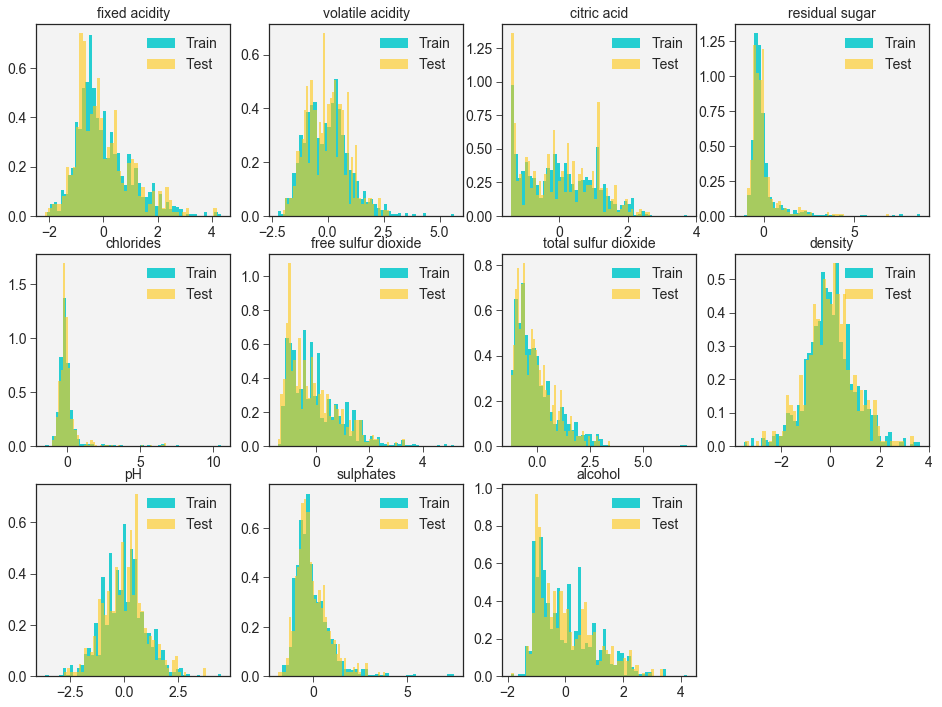

In [5]:
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.titlesize': 20})

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3, 4, (feat_idx+1), facecolor='#f3f3f3')
    h = ax.hist(X_train_std[:, feat_idx], bins=50, normed=True, color='#25ced1', edgecolor='none', label='Train')
    h = ax.hist(X_test_std[:, feat_idx], bins=50, normed=True, color='#ffc91499', edgecolor='none', label='Test')
    ax.set_title(data.columns[feat_idx], fontsize=14)
    ax.legend(loc="upper right")

## Etape 2: Optimisation du modèle k-NN

### Paramètrage du modèle
Définitions des hyperparamètres à tester et initialisation des folds pour la validation croisée.

Les folds ne sont pas générés aléatoirement (pour pouvoir mieux comparer les résultats) grâce à <code>shuffle=False</code> et <code>random_state=0</code>

In [6]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}

# Initialisation des folds
cross_validation_folds = model_selection.StratifiedKFold(
    n_splits=5, # nombre de folds de validation croisée
    shuffle=False,
    random_state=0
)


### Code de l'implémentation personnalisée

In [7]:
import itertools as it

class MyCrossValidation:
    def __init__(self, estimator, param_grid, cv):
        """Constructeur
        
        Args:
            estimator (object): classificateur à valider
            param_grid (dict): hyperparamètres à tester
            cv (object): algorithme de création des folds
        """
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.cv_results_ = []
    
    def fit(self, X, y):
        """Lance le calcul avec les jeux de données fournis
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
        """
        # pour chaque combinaison d'hyperparamètres
        for hyper_parameters in self.get_hyper_parameter_combinations():
            # evaluer la performance du modèle
            self.eval_performance_for_params(X, y, hyper_parameters)
        
        self.consolidate_results()
        self.setup_best_estimator(X, y)
        
    def get_hyper_parameter_combinations(self):
        """
        Calcule les différentes combinaisons de la grille des hyper-paramètres
        
        Par exemple {'P': [0, 1, 2]} devient [{'P': 0}, {'P': 1}, {'P': 2}]
        """
        names = sorted(self.param_grid)
        return [dict(zip(names, prod)) for prod in it.product(*(self.param_grid[name] for name in names))]
    
    def eval_performance_for_params(self, X, y, hyper_parameters):
        """
        Estime la performance du modèle suivant les hyperparamètres fournis,
        à l'aide d'une validation croisée, et stocke les résultats
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
            hyper_parameters (dict): hyperparamètres utilisés pour le modèle à évaluer
        """
        self.estimator.set_params(**hyper_parameters)
        scores = list(self.eval_performance_for_each_fold(X, y))
        self.store_results(hyper_parameters, scores)
        
    def eval_performance_for_each_fold(self, X, y):
        """
        Estime la performance du modèle à l'aide d'une validation croisée,
        pour chaque fold défini par self.cv
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
            
        Yields:
            object: pour chaque fold, la mean_squared_error et le coefficient R2
        """
        # pour chaque fold
        fold_indices = self.cv.split(X, y)
        for train_index, validation_index in fold_indices:
            # recuperation des sets pour le fold en cours
            X_train = X[train_index]
            X_validation = X[validation_index]
            y_train = y[train_index]
            y_validation = y[validation_index]
            
            # entrainement de l'estimateur
            self.estimator.fit(X_train, y_train)
            
            # évaluation de la performance pour ce fold
            y_pred = self.estimator.predict(X_validation)
            yield {
                'mean_squared_error': metrics.mean_squared_error(y_validation, y_pred),
                'r2_score': metrics.r2_score(y_validation, y_pred)
            }
    
    def store_results(self, hyper_parameters, scores):
        self.cv_results_.append({
            'params': hyper_parameters,
            # La MSE globale est égale à la moyenne arithmétique des MSE de chaque fold
            'mean_squared_error': np.mean([x['mean_squared_error'] for x in scores]),
            'mean_squared_error_std': np.std([x['mean_squared_error'] for x in scores]),
            # La R^2 globale est estimée avec la moyenne arithmétique des R^2 de chaque fold
            # même si ce n'est pas tout à fait exact mathématiquement
            'r2_score': np.mean([x['r2_score'] for x in scores]),
            'r2_score_std': np.std([x['r2_score'] for x in scores]),
            'scores': scores
        })
    
    def consolidate_results(self):
        """Convertit les résultats au format DataFrame"""
        self.cv_results_ = pd.DataFrame(self.cv_results_)
    
    @property
    def best_params_(self):
        """Recupère les meilleurs hyperparamètres"""
        idx_max = self.cv_results_['mean_squared_error'].idxmin()
        return self.cv_results_['params'][idx_max]
    
    def setup_best_estimator(self, X, y):
        """Initialise un estimateur avec les meilleurs hyperparamètres,
        qui est ensuite entraîné avec les données fournies
        
        Args:
            X (array-like, sparse matrix): variables features 
            y (array-like, sparse matrix): variables cible (target)
        """
        hyper_parameters = self.best_params_
        self.estimator.set_params(**hyper_parameters)
        self.estimator.fit(X, y)
        
    def predict(self, X):
        """Réalise une prédiction avec l'estimateur avec les meilleurs
        hyperparamètres
        
        Args:
            X (array-like, sparse matrix): variables features
        """
        return self.estimator.predict(X)


### Lancement de l'estimation

In [8]:
mcv = MyCrossValidation(neighbors.KNeighborsRegressor(),
    param_grid, # hyperparamètres à tester
    cv=cross_validation_folds # validation croisée
    )

# Optimiser ce classifieur sur le jeu d'entraînement
mcv.fit(X_train_std, y_train)

### Résultats de la validation croisée

In [9]:
# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (mcv.best_params_)

my_cross_validation_results = pd.DataFrame.from_dict(
    {
        'MSE moyen' : mcv.cv_results_['mean_squared_error'],
        'écart-type de la MSE': mcv.cv_results_['mean_squared_error_std'] * 2,
        'R^2 moyen' : mcv.cv_results_['r2_score'],
        'écart-type de R^2': mcv.cv_results_['r2_score_std'] * 2,
        'hyperparamètres': mcv.cv_results_['params']
    })

my_cross_validation_results

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}


,MSE moyen,R^2 moyen,hyperparamètres,écart-type de R^2,écart-type de la MSE
0,0.488816,0.278707,{'n_neighbors': 3},0.108559,0.093539
1,0.469296,0.307415,{'n_neighbors': 5},0.064741,0.066886
2,0.453042,0.331351,{'n_neighbors': 7},0.050574,0.058253
3,0.443908,0.344354,{'n_neighbors': 9},0.030615,0.037374
4,0.440525,0.349074,{'n_neighbors': 11},0.034249,0.028641
5,0.434967,0.357660,{'n_neighbors': 13},0.025701,0.038043
6,0.434013,0.359171,{'n_neighbors': 15},0.032672,0.043055
7,0.436959,0.354700,{'n_neighbors': 17},0.035277,0.041084
8,0.439956,0.350361,{'n_neighbors': 19},0.038676,0.044914
9,0.439449,0.351145,{'n_neighbors': 21},0.043645,0.047901


In [10]:
y_pred = mcv.predict(X_test_std)
print ("\nSur le jeu de test : %0.3f" % metrics.mean_squared_error(y_test, y_pred))


Sur le jeu de test : 0.461


### Résultats fournis par scikit
Pour vérification, une validation croisée avec <code>GridSearchCV</code> est lancée

On constate que les résultats sont quasiment identiques

In [11]:
# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(neighbors.KNeighborsRegressor(),
    param_grid, # hyperparamètres à tester
    cv=cross_validation_folds, # validation croisée
    scoring='neg_mean_squared_error' # score à optimiser
    )

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (clf.best_params_)

y_pred = clf.predict(X_test_std)
print ("\nSur le jeu de test : %0.3f" % metrics.mean_squared_error(y_test, y_pred))

pd.DataFrame.from_dict(
    {
        'score moyen' : clf.cv_results_['mean_test_score'],
        'hyperparamètres': clf.cv_results_['params']
    })

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}

Sur le jeu de test : 0.461


,hyperparamètres,score moyen
0,{'n_neighbors': 3},-0.489127
1,{'n_neighbors': 5},-0.469562
2,{'n_neighbors': 7},-0.453284
3,{'n_neighbors': 9},-0.444080
4,{'n_neighbors': 11},-0.440631
5,{'n_neighbors': 13},-0.435141
6,{'n_neighbors': 15},-0.434201
7,{'n_neighbors': 17},-0.437143
8,{'n_neighbors': 19},-0.440161
9,{'n_neighbors': 21},-0.439664


### Analyse du comportement de la MSE
Ce graphique présente l'évolution de la MSE en fonction des hyperparamètres

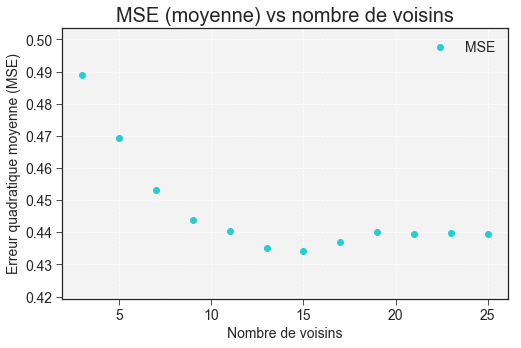

In [12]:
x = [x['n_neighbors'] for x in mcv.cv_results_['params']]
data = mcv.cv_results_['mean_squared_error'].tolist()

fig = plt.figure(figsize=(8,5))
ax = plt.axes(facecolor='#f3f3f3')
plt.grid(color='w', linestyle='dashed')
plt.scatter(x, data, label='MSE', color='#25ced1')
plt.title("MSE (moyenne) vs nombre de voisins")
plt.legend(loc='best')
ax.set(xlabel='Nombre de voisins', ylabel='Erreur quadratique moyenne (MSE)')
plt.show()

L'erreur quadratique moyenne diminue avec l'évolution du nombre de voisins. Or plus l'erreur est faible plus l'estimateur fournit de bons résultats. Il semble donc que le meilleur hyperparamètre est donc le nombre de voisins <code>k = 15</code>)

L'augmentation du nombre de voisins semble améliorer le comportement du modèle, mais de manière asymptotique et jusqu'à un certain seuil, au delà duquel la qualité des prédictions semble stagner (voire redevenir moins bonne).

Pour optimiser les temps de calcul on a donc intérêt à conserver l'hyperparamètre le plus faible à partir duquel la qualité des prédictions est acceptable.

### Analyse du comportement de la R^2
Ce graphique présente l'évolution de la R^2 en fonction des hyperparamètres

La MSE est aussi affichée, pour comparaison

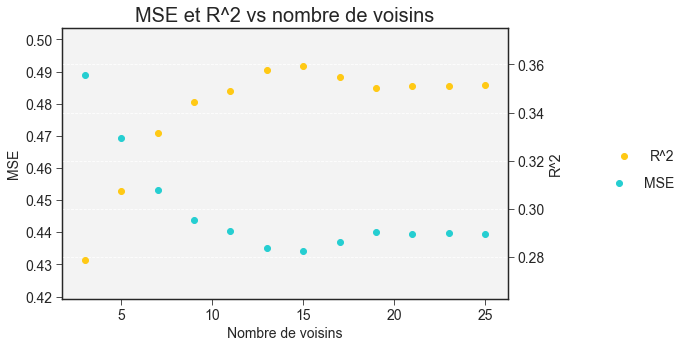

In [13]:
x = [x['n_neighbors'] for x in mcv.cv_results_['params']]
data_1 = mcv.cv_results_['mean_squared_error'].tolist()
data_2 = mcv.cv_results_['r2_score'].tolist()

fig = plt.figure(figsize=(8,5))
ax1 = plt.axes(facecolor='#f3f3f3')
ax1.scatter(x, data_1, label='MSE', color='#25ced1')
ax1.set(xlabel='Nombre de voisins', ylabel='MSE')
ax1.legend(bbox_to_anchor=(1.4, .5), loc='upper right')

ax2 = ax1.twinx()
ax2.scatter(x, data_2, label='R^2', color='#ffc914')
ax2.set(xlabel='Nombre de voisins', ylabel='R^2')
ax2.legend(bbox_to_anchor=(1.4, .6), loc='upper right')

plt.grid(color='w', linestyle='dashed')
plt.title("MSE et R^2 vs nombre de voisins")

plt.show()

Inversement à la MSE, le coefficient de détermination augmente avec l'évolution du nombre de voisins. Plus il est grand plus les valeurs prédites sont correlées avec les valeurs réelles.

Les deux valeurs semblent évoluer de manière semblable.

Le graphique suivant présente la relation entre les valeurs prédites et les valeurs réelles sur le jeu de test, avec l'estimateur avec les meilleurs hyperparamètres.

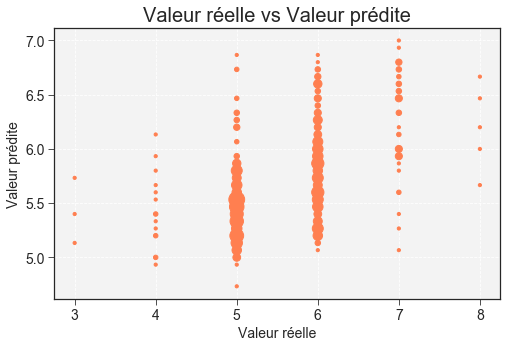

In [14]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()

fig = plt.figure(figsize=(8,5))
ax = plt.axes(facecolor='#f3f3f3')
plt.grid(color='w', linestyle='dashed')
plt.scatter([k[0] for k in keys], # vraie valeur (abscisse)
[k[1] for k in keys], # valeur predite (ordonnee)
s=[sizes[k] * 10 for k in keys], # taille du marqueur
color='coral')

plt.title("Valeur réelle vs Valeur prédite")
ax.set(xlabel='Valeur réelle', ylabel='Valeur prédite')
plt.show()

On note une accumulation de prédictions correctes sur la diagonale. Néanmoins le modèle n'est pas très précis dans ses prédictions. Cela fait partie des limites du k-NN.

## Etape 3. Comparaison des résultats avec des approches naïves
### Modèle aléatoire

Comparons le modèle à une première approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [15]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)
print("RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_random)))

RMSE : 1.799


Pour mémoire, la RMSE de notre modèle k-NN optimisé

In [16]:
y_pred = mcv.predict(X_test_std)
print ("RMSE: %.3f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 0.679


Notre modèle a ainsi réussi à bien mieux apprendre qu'un modèle aléatoire.

Comparons notre modèle à un modèle qui retourne la valeur moyenne des étiquettes du jeu de données d'entraînement.

In [17]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)))

RMSE : 0.770


Le kNN a donc appris plus que la moyenne des étiquettes.

Comparons notre modèle à un modèle qui retourne la valeur médiane des étiquettes du jeu de données d'entraînement.

In [18]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='median')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)))

RMSE : 0.866
